In [14]:
# import argparse
import os
import pickle
# import time
# from itertools import product
# from math import inf, pi

import jax
import jax.numpy as jnp
from jax.experimental.ode import odeint
import jax.debug as jdb
from functools import partial
import numpy as np

from tqdm.auto import tqdm

# from dynamics import prior, disturbance, plant
# from utils import params_to_posdef
from utils import random_ragged_spline, spline
from utils import (tree_normsq, rk38_step, epoch,   # noqa: E402
                   odeint_fixed_step, odeint_ckpt, random_ragged_spline, spline,
            params_to_cholesky, params_to_posdef, vee, hat,
            
            quaternion_to_rotation_matrix, flat_rotation_matrix_to_quaternion, 
            quaternion_multiply)

# from functools import partial
import matplotlib.pyplot as plt
# import csv

plt.rcParams.update({'font.size': 24})

In [15]:
def validate_model(raw, epoch_i, print_=False, plot=False):
    hparams = raw['hparams']
    dt = hparams['meta']['dt']
    T = hparams['meta']['T']
    num_refs = hparams['meta']['num_refs']
    coefs = raw['coefs']
    max_ref = raw['max_ref']
    min_ref = raw['min_ref']
    t_knots = raw['t_knots']

    A = raw['train_lossaux_history'][epoch_i]['A']
    # W = raw['train_lossaux_history'][epoch_i]['W']
    # b = raw['train_lossaux_history'][epoch_i]['b']
    eigs_K = raw['train_lossaux_history'][epoch_i]['eigs_K']
    eigs_P = raw['train_lossaux_history'][epoch_i]['eigs_P']
    eigs_Λ = raw['train_lossaux_history'][epoch_i]['eigs_Λ']
    control_loss = raw['train_lossaux_history'][epoch_i]['control_loss']
    estimation_loss = raw['train_lossaux_history'][epoch_i]['estimation_loss']
    tracking_loss = raw['train_lossaux_history'][epoch_i]['tracking_loss']
    l2_penalty = raw['train_lossaux_history'][epoch_i]['l2_penalty']
    reg_P_penalty = raw['train_lossaux_history'][epoch_i]['reg_P_penalty']
    pnorm = raw['train_lossaux_history'][epoch_i]['pnorm']
    x = raw['train_lossaux_history'][epoch_i]['x']

    mystery_i = 0

    if plot:
        def reference(t):
            # print([spline(t, t_knots[mystery_i], c[mystery_i]) for c in coefs])
            r = jnp.array([spline(t, t_knots[mystery_i], c[mystery_i]) for c in coefs]) + jnp.array([0, 0, 1])
            r = jnp.clip(r, min_ref, max_ref)
            return r

        num_steps = int(np.maximum(np.abs((T - 0)/dt), 1))
        ts = jnp.linspace(0, T, num_steps + 1)
        r = jax.vmap(reference)(ts)
        dr = jax.vmap(jax.jacfwd(reference))(ts)

        fig, ax = plt.subplots(1, 3, figsize=(30, 10))
        ax[0].plot(ts, x[:, 0], 'r-', label='q')
        ax[0].plot(ts, r[:, 0], 'b--', label='r')
        ax[0].set_ylabel('x')
        ax[0].set_xlabel('t')
        ax[0].legend()

        ax[1].plot(ts, x[:, 1], 'r-', label='q')
        ax[1].plot(ts, r[:, 1], 'b--', label='r')
        ax[1].set_ylabel('y')
        ax[1].set_xlabel('t')
        ax[1].legend()

        ax[2].plot(ts, x[:, 2], 'r-', label='q')
        ax[2].plot(ts, r[:, 2], 'b--', label='r')
        ax[2].set_ylabel('z')
        ax[2].set_xlabel('t')
        ax[2].legend()
        
        fig.suptitle(f'Position')
        fig.tight_layout()

        fig, ax = plt.subplots(1, 3, figsize=(30, 10))
        ax[0].plot(ts, x[:, 3], 'r-', label='dq')
        ax[0].plot(ts, dr[:, 0], 'b--', label='dr')
        ax[0].set_ylabel('dx')
        ax[0].set_xlabel('t')
        ax[0].legend()

        ax[1].plot(ts, x[:, 4], 'r-', label='dq')
        ax[1].plot(ts, dr[:, 1], 'b--', label='dr')
        ax[1].set_ylabel('dy')
        ax[1].set_xlabel('t')
        ax[1].legend()

        ax[2].plot(ts, x[:, 5], 'r-', label='dq')
        ax[2].plot(ts, dr[:, 2], 'b--', label='dr')
        ax[2].set_ylabel('dz')
        ax[2].set_xlabel('t')
        ax[2].legend()
        
        fig.suptitle(f'Velocity')
        fig.tight_layout()

        A_norm = jnp.linalg.norm(A, axis=(1,2))

        fig, ax = plt.subplots(1, 2, figsize=(30, 10))

        ax[0].plot(ts, A_norm, label='A')
        ax[0].set_ylabel('A')
        ax[0].set_xlabel('t')
        ax[0].legend()

    num_models = len(control_loss)

    control_loss = jnp.sum(control_loss)
    estimation_loss = jnp.sum(estimation_loss)
    tracking_loss = jnp.sum(tracking_loss)

    normalizer = T * num_refs * num_models

    regularizer_l2 = hparams['meta']['regularizer_l2']
    regularizer_ctrl = hparams['meta']['regularizer_ctrl']
    regularizer_error = hparams['meta']['regularizer_error']
    regularizer_P = hparams['meta']['regularizer_P']

    loss = (tracking_loss
                + regularizer_ctrl*control_loss
                + regularizer_error*estimation_loss
                + regularizer_l2*l2_penalty
                ) / normalizer + regularizer_P * reg_P_penalty

    # total_loss_norm = loss
    tracking_loss_norm = tracking_loss/normalizer
    control_loss_norm = regularizer_ctrl*control_loss/normalizer
    estimation_loss_norm = regularizer_error*estimation_loss/normalizer
    l2_penalty_norm = regularizer_l2*l2_penalty/normalizer
    reg_P_penalty_norm = regularizer_P*reg_P_penalty

    if print_:
        print('\nLoss at epoch:', epoch_i)
        print('\tTraining loss:                   ', loss)
        print('\tNormalized tracking_loss_norm:   ', tracking_loss_norm)
        print('\tNormalized control_loss_norm:    ', control_loss_norm)
        print('\tNormalized l2_penalty_norm:      ', l2_penalty_norm)
        print('\tNormalized reg_P_penalty_norm:   ', reg_P_penalty_norm)

        print('\nEigenvalues of P:', eigs_P)
        # print('eigs_Λ:', eigs_Λ)
        # print('eigs_K:', eigs_K)

    return loss, tracking_loss_norm, control_loss_norm, reg_P_penalty_norm, l2_penalty_norm

def plot_losses(raw, xlim=[0, 1000]):
    total_losses = []
    tracking_losses = []
    control_losses = []
    reg_P_penalties = []
    E = int(raw['hparams']['ensemble']['num_epochs'])
    for epoch_i in range(E):
        losses = validate_model(raw, epoch_i, print_=False, plot=False)
        total_losses.append(losses[0])
        tracking_losses.append(losses[1])
        control_losses.append(losses[2])
        reg_P_penalties.append(losses[3])

    fig, ax = plt.subplots(1, 4, figsize=(30, 10))
    ax[0].plot(range(E), total_losses)
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_xlim(xlim)
    ax[0].set_title('Training Loss')

    ax[1].plot(range(E), tracking_losses)
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_xlim(xlim)
    ax[1].set_title('Tracking Loss')

    ax[2].plot(range(E), control_losses)
    ax[2].set_ylabel('Loss')
    ax[2].set_xlabel('Epoch')
    ax[2].set_xlim(xlim)
    ax[2].set_title('Control Loss')

    ax[3].plot(range(E), reg_P_penalties)
    ax[3].set_ylabel('Loss')
    ax[3].set_xlabel('Epoch')
    ax[3].set_xlim(xlim)
    ax[3].set_title('reg_P_penalty')

    # print(total_losses[-1])
    # print(tracking_losses[-1])
    # print(control_losses[-1])
    # print(reg_P_penalties[-1])
    # fig.suptitle(f'Losses')
    fig.tight_layout()

Best epoch: 809

Loss at epoch: 999
	Training loss:                    0.025727618
	Normalized tracking_loss_norm:    0.002021555
	Normalized control_loss_norm:     0.022391163
	Normalized l2_penalty_norm:       1.0269365e-05
	Normalized reg_P_penalty_norm:    0.0013046336

Eigenvalues of P: [1.0625255  1.1764714  1.149421   1.2221584  1.069124   1.0526584
 1.1976364  1.1270686  1.0489304  1.1461699  1.0177225  1.0998924
 1.1153691  1.0484531  1.084964   1.1564908  1.0045855  1.0278964
 1.0195034  1.00748    1.0767182  1.0492896  0.99005276 1.0604533
 1.0054866  1.0471191  1.051244   1.054701   1.0462056  1.0445098
 0.9564342  1.0301201 ]


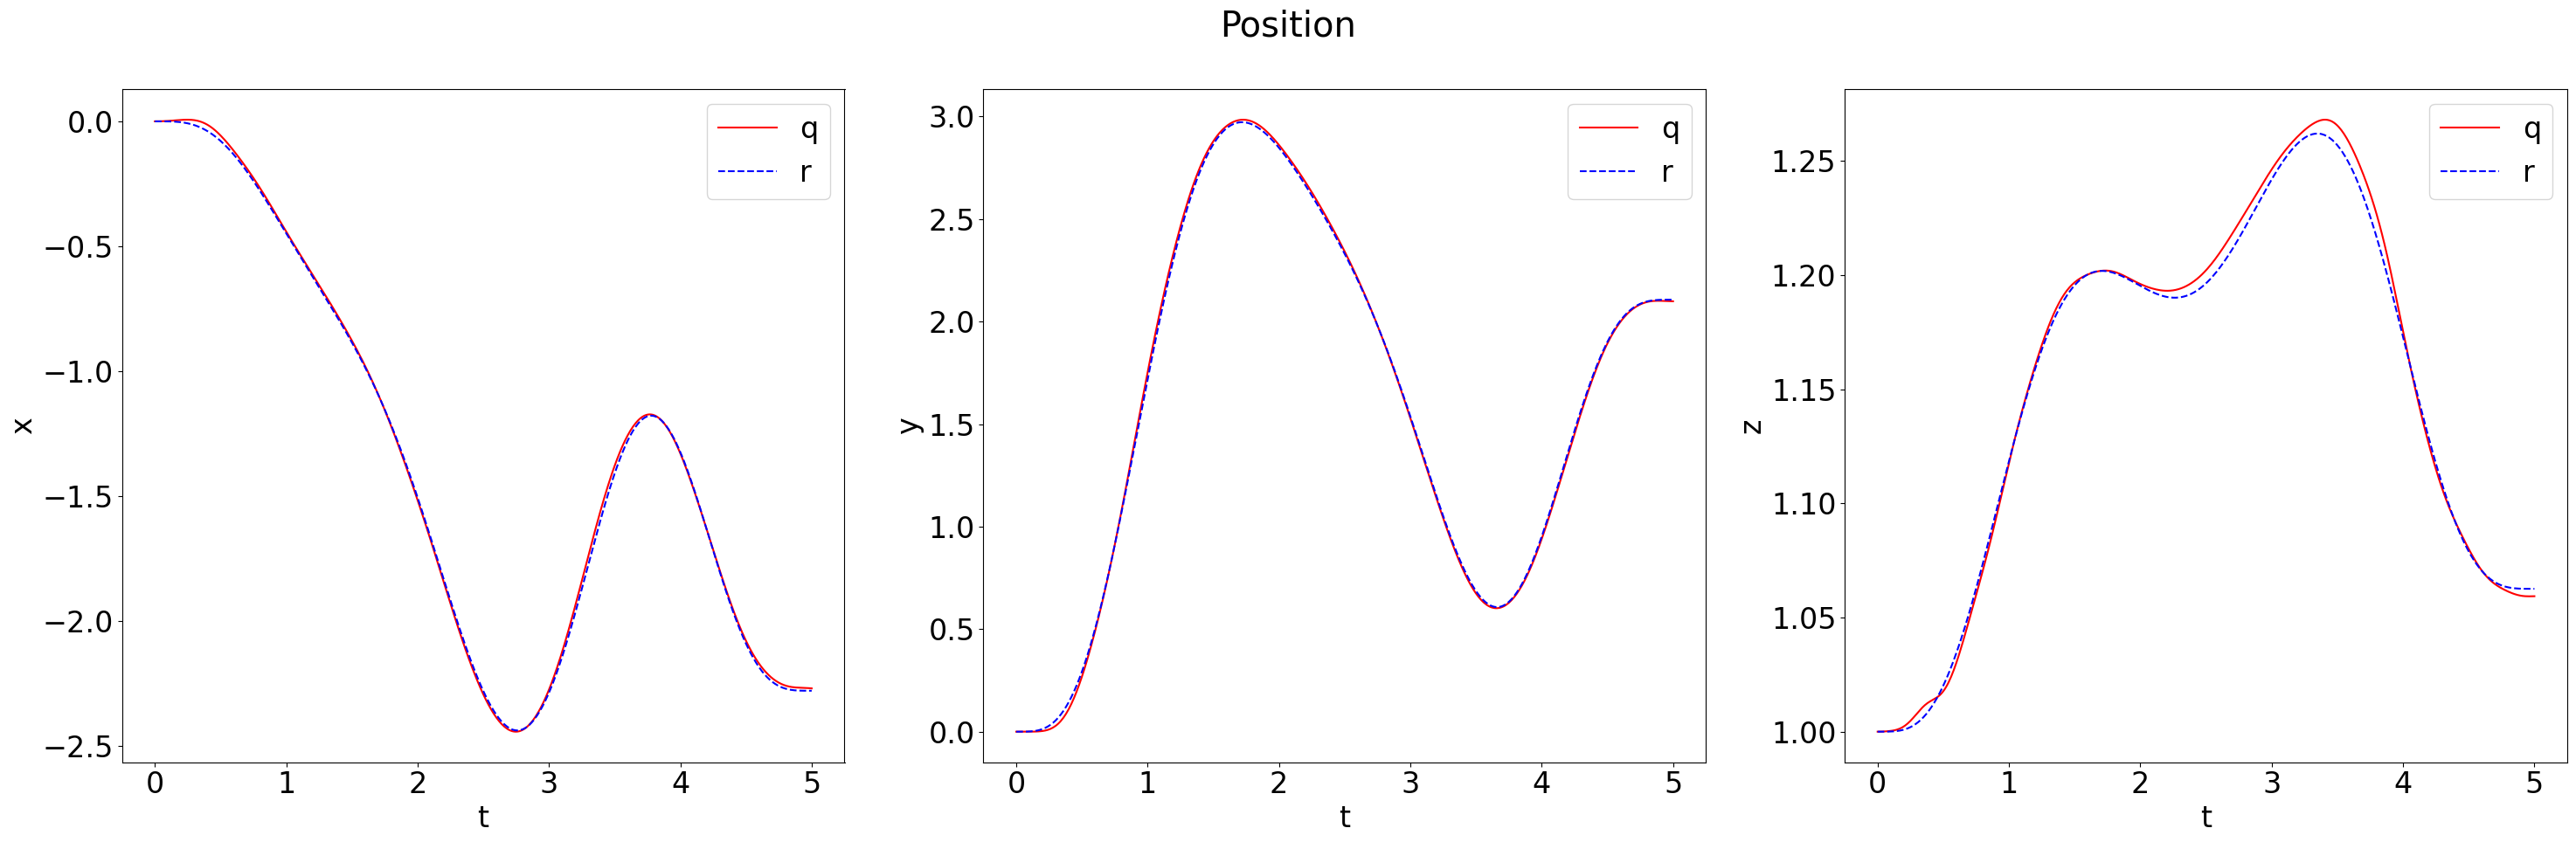

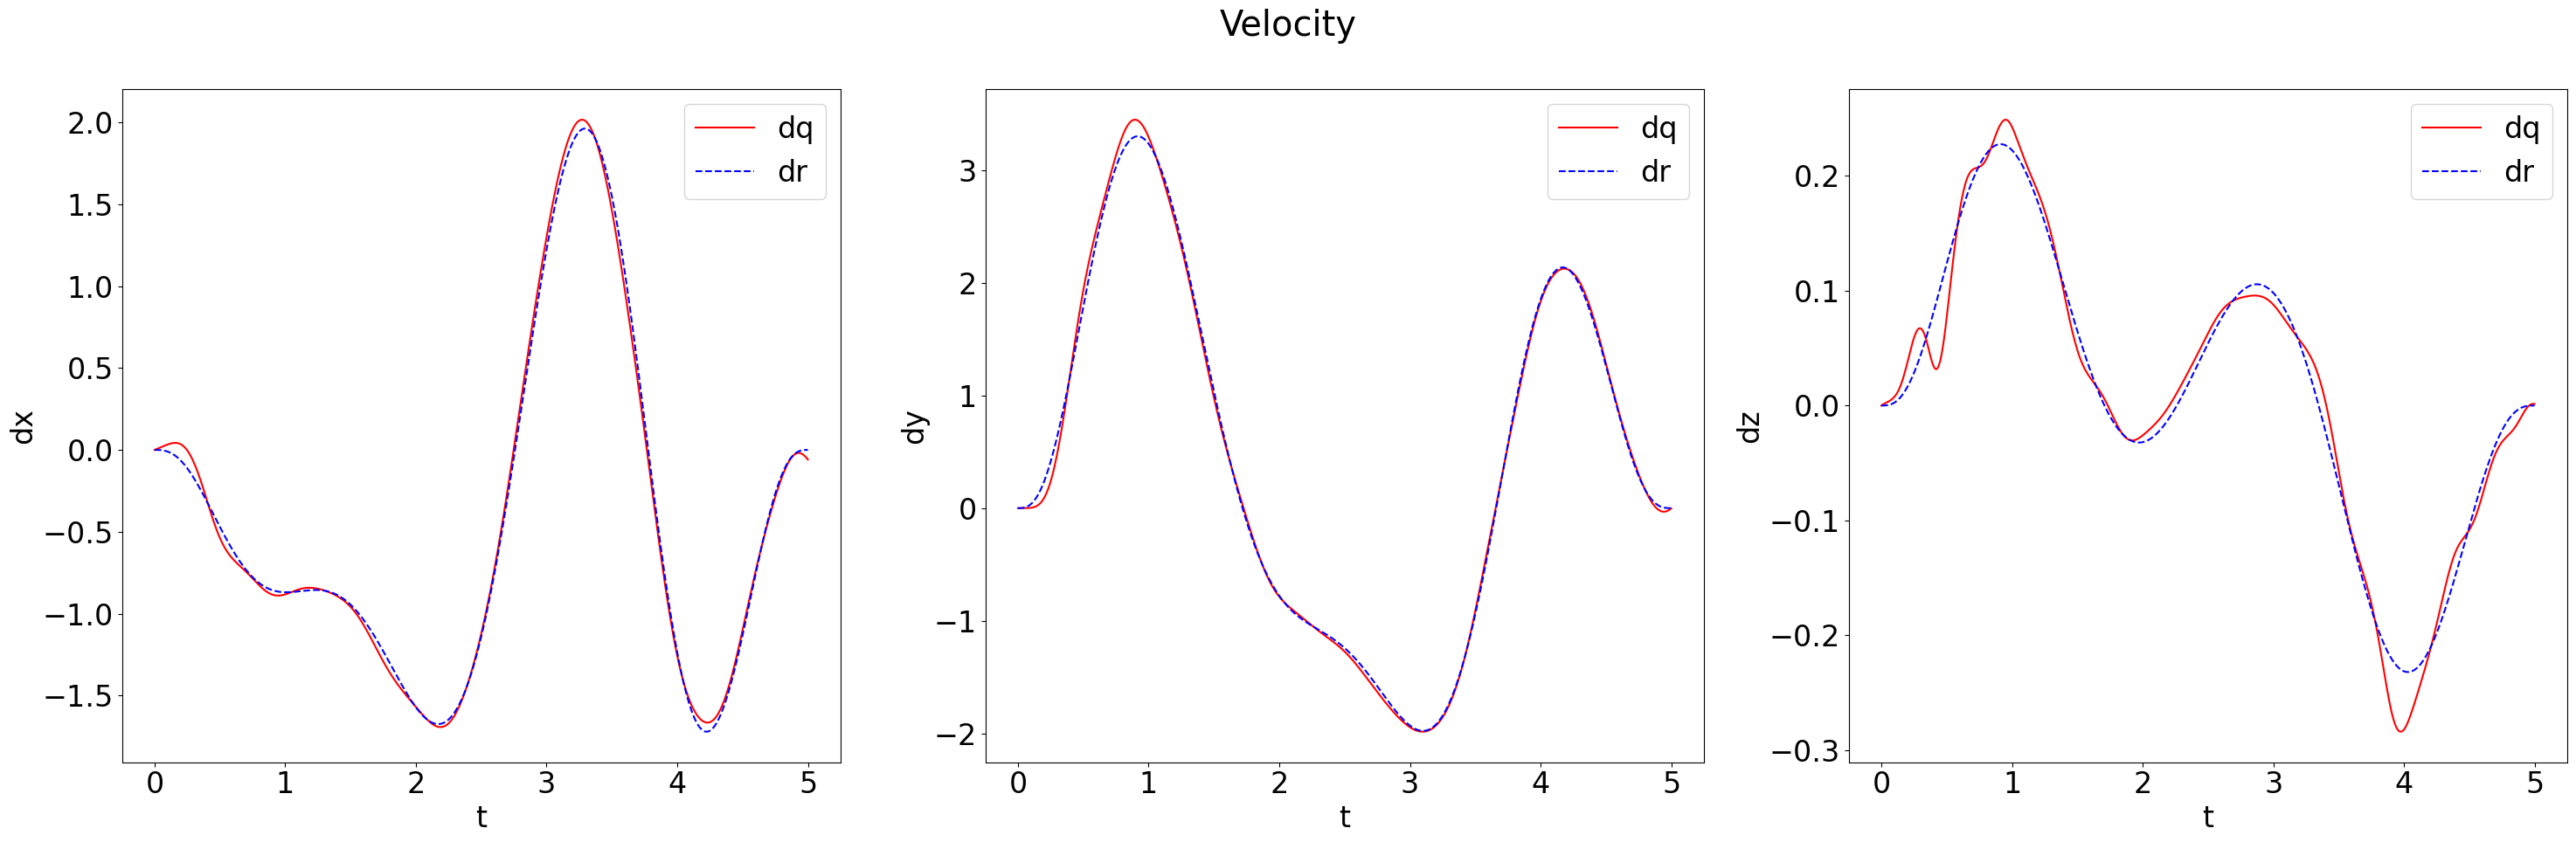

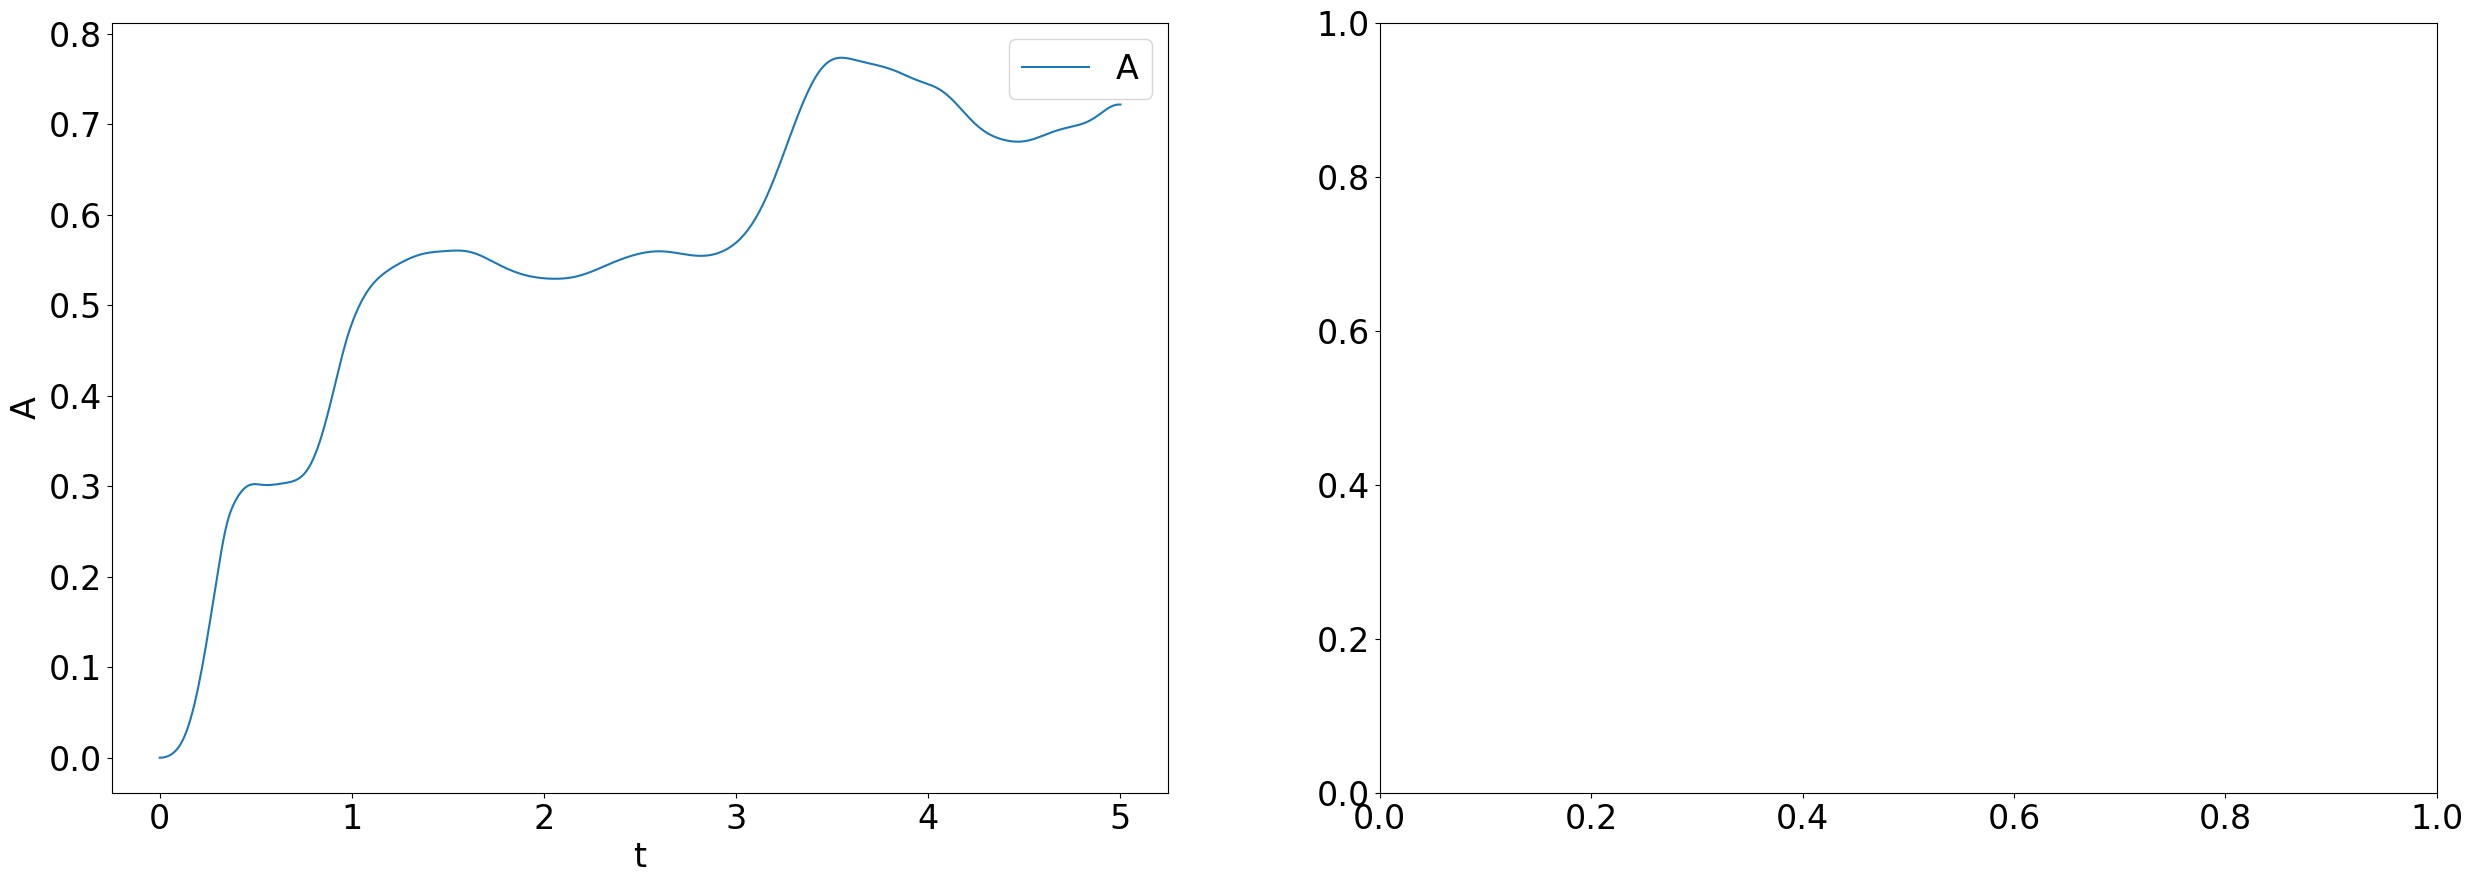

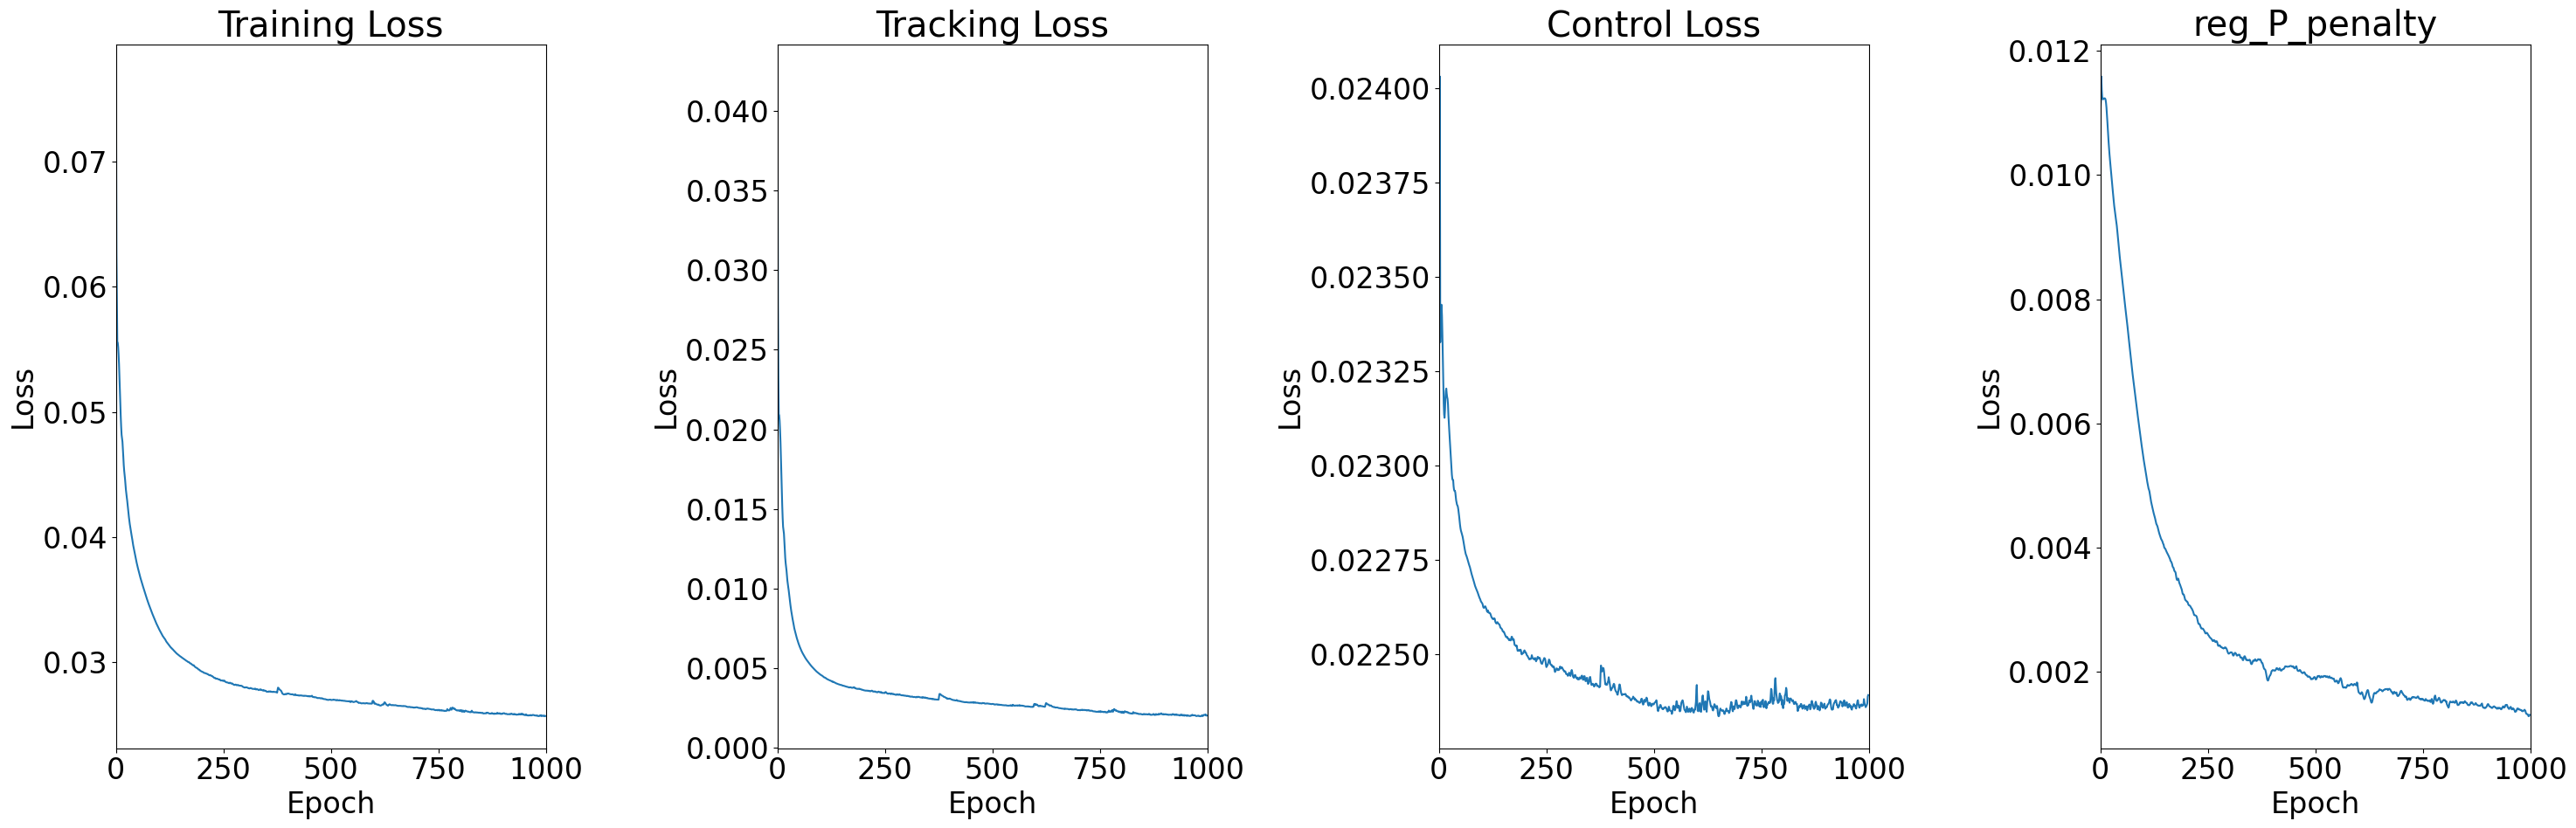

In [16]:
# trial_name = 'hardware_reg_P_1e-1'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=0.1000.pkl'
# trial_name = 'hardware_reg_P_1e-2'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=0.0100.pkl'
# trial_name = 'hardware_mac_kR_reg_P_1'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=1.0000.pkl'
# trial_name = 'hardware_mac_kR_reg_P_10'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=10.0000.pkl'
# trial_name = 'hardware_mac_kR_reg_P_100'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=100.0000.pkl'
# trial_name = 'hardware_ubuntu_kR_reg_P_500'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=500.0000.pkl'
# trial_name = 'hardware_ubuntu_smallP_reg_P_1e-1'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=0.1000.pkl'
# trial_name = 'hardware_ubuntu_smallP_reg_P_1'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=1.0000.pkl'
# trial_name = 'hardware_ubuntu_smallP_reg_P_10'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=10.0000.pkl'
# trial_name = 'hardware_ubuntu_smallP_reg_P_100'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=100.0000.pkl'
# trial_name = 'hardware_11'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=0.1000.pkl'
# trial_name = 'hardware_12'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=0.1000.pkl'
# trial_name = 'hardware_13'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=0.0000.pkl'
# trial_name = 'hardware_14'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=0.0000.pkl'
# trial_name = 'hardware_15'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=0.0000.pkl'
trial_name = 'hardware_16'
filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=0.0020.pkl'

pkl = f'{trial_name}/{filename}'
with open(f'train_results/{pkl}', 'rb') as file:
    raw = pickle.load(file)

print('Best epoch:', raw['best_step_meta'])

validate_model(raw, 999, print_=True, plot=True)
    
E = int(raw['hparams']['ensemble']['num_epochs'])
plot_losses(raw)
# plot_losses(raw, xlim=[850,E])
# plot_losses(raw, xlim=[850,E], ylim=[0,2])